In [63]:
import os
from astropy.io import ascii as asc
from astropy.time import Time
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import astropy.units as u
from utilities_az import supernova, connect_to_sndavis

from astropy.modeling import fitting, models

This analysis builds on the work in SNEC_input_analysis notebook

In [67]:
plt.style.use(['seaborn-paper', 'az-paper-twocol'])

In [2]:
FIG_DIR = '../figures'

In [3]:
tbdata = asc.read('../data/asassn15oz_bolo_UBgVrRiI.txt', names=['phase', 'logL', 'err'])

In [6]:
sn15oz = supernova.LightCurve2('asassn-15oz')
sn15oz.get_photometry('V')
sn15oz.get_slope('s2', band='V')
sn15oz.get_slope('s50', band='V')
sn15oz.get_slope('tail')
Time(sn15oz.jdexpl, format='jd').iso

'2015-08-27 12:00:00.000'

In [7]:
lc_tbdata = asc.read('../data/tpt3_bolo.txt', data_start=1)
w0_avg = -np.median(lc_tbdata['w0'])/50. #mag/50d --> mag/d

# Fit Light Curve

In [8]:
lin_model = models.Linear1D()
fitter = fitting.LinearLSQFitter()

## Find s2 parameters

In [9]:
s2_indx = (tbdata['phase']>50) & (tbdata['phase']<100)
s2_fit = fitter(lin_model, tbdata['phase'][s2_indx], tbdata['logL'][s2_indx], weights=1/tbdata['err'][s2_indx])

## Find tail parameters

There is a slight change/scatter in slope of the tail, so we are just fitting to day 300 rather than the full 400 days to better match the early time slope

In [10]:
tail_indx = (tbdata['phase']>100) & (tbdata['phase']<300)
tail_fit = fitter(lin_model, tbdata['phase'][tail_indx], tbdata['logL'][tail_indx], weights=1/tbdata['err'][tail_indx])

In [11]:
start_fall_phase = tbdata['phase'][s2_indx][-1]
start_fall_lum = tbdata['logL'][s2_indx][-1]
end_tail_phase = tbdata['phase'][tail_indx][-1]
end_tail_lum = tbdata['logL'][tail_indx][-1]

# Figure out the right value for $t_{pt}$

SN asassn14gm not found in database
not plotted ASASSN-14g, not in DB
SN asassn14dq not found in database
not plotted ASASSN-14d, not in DB
SN asassn14ha not found in database
not plotted ASASSN-14h, not in DB


/Users/bostroem/anaconda/lib/python3.5/site-packages/astropy/table/row.py:55: StringTruncateWarning: truncated right side string(s) longer than 10 character(s) during assignment
  self._table.columns[item][self._index] = val
/Users/bostroem/anaconda/lib/python3.5/site-packages/astropy/table/row.py:55: StringTruncateWarning: truncated right side string(s) longer than 10 character(s) during assignment
  self._table.columns[item][self._index] = val


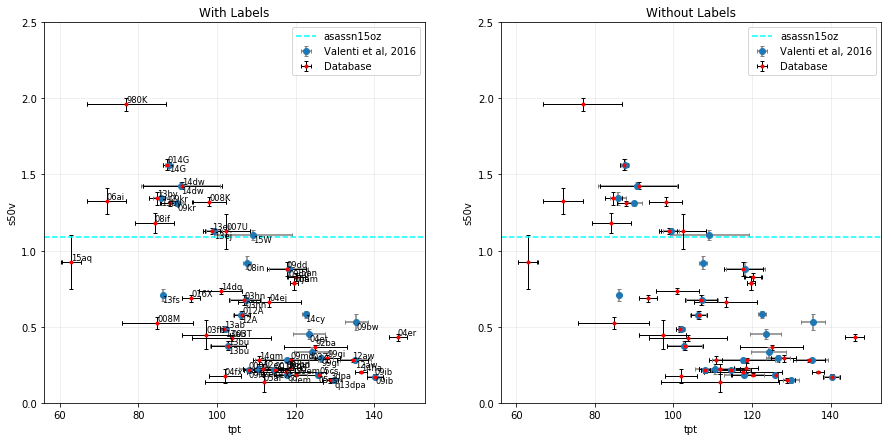

In [12]:
fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
slopes = []
jdexpl_err = []
slope_err = []
for irow in lc_tbdata:
    sn_lc = supernova.LightCurve2(irow['SN'])
    if 'asassn' in irow['SN'] and sn_lc.id is None:
        irow['SN'] = 'ASASSN-{}'.format(irow['SN'].strip('asassn'))
    if sn_lc.id is not None:
        sn_lc.get_slope('s50', 'V')
        if sn_lc.slopes['s50']['V'] is not None:
            ax1.text(irow['tpt']-irow['JD'],sn_lc.slopes['s50']['V']*50, irow['SN'][2:], va='top', fontsize='small')
            jdexpl_err.append(sn_lc.jdexpl_err)
            slopes.append(sn_lc.slopes['s50']['V'])
            slope_err.append(sn_lc.slopes['s50_err']['V'])
        else:
            slopes.append(np.nan)
            slope_err.append(np.nan)
            jdexpl_err.append(np.nan)
            print('not plotted {}; no s50V'.format(irow['SN']))
    else:
        slopes.append(np.nan)
        slope_err.append(np.nan)
        jdexpl_err.append(np.nan)
        print('not plotted {}, not in DB'.format(irow['SN']))

tpt_err = np.sqrt(np.array((lc_tbdata['tpt-'], lc_tbdata['tpt+']))**2+np.array(jdexpl_err)**2)
slopes = np.array(slopes)*50
slope_err = np.array(slope_err)*50
ax1.errorbar(lc_tbdata['tpt']-lc_tbdata['JD'],slopes,xerr=tpt_err,  yerr=slope_err, fmt='o',  label='Valenti et al, 2016', ecolor='gray', capsize=2)
ax1.set_ylabel('s50v')
ax1.set_xlabel('tpt')
ax1.set_ylim(0, 2.5)
ax2.errorbar(lc_tbdata['tpt']-lc_tbdata['JD'],slopes,xerr=tpt_err,  yerr=slope_err, fmt='o',  label='Valenti et al, 2016', ecolor='gray', capsize=2)
ax2.set_ylabel('s50v')
ax2.set_xlabel('tpt')
ax2.set_ylim(0, 2.5)
#plt.xlim(50, 150)

sql = '''SELECT snslope.`slope`, snslope.`slopeerr`, idsupernovae.`jdexpl`, idsupernovae.`jdexplerr`,  supernovanames.`name`, 
sntpt.`jdtpt`, sntpt.`jdtpterr1`, sntpt.`jdtpterr2` FROM
sntpt JOIN idsupernovae ON idsupernovae.`id`=sntpt.`targetid` 
JOIN snslope ON snslope.`targetid`=idsupernovae.`id`
JOIN supernovanames ON supernovanames.`targetid`=idsupernovae.`id`
where snslope.`slopetype`="s50" and snslope.`filter`="V" and sntpt.`filter`="V"'''
db, cursor = connect_to_sndavis.get_cursor()
cursor.execute(sql)
result = cursor.fetchall()
for isn in result:
    tpt_err = np.sqrt(np.array([(isn['jdtpterr1'], isn['jdtpterr2'])])**2+isn['jdexplerr']**2)
    ax1.errorbar(isn['jdtpt']-isn['jdexpl'], isn['slope']*50, xerr=tpt_err, yerr=isn['slopeerr']*50, fmt='r.', ecolor='k', capsize=2, elinewidth=1)
    ax1.text(isn['jdtpt']-isn['jdexpl'], isn['slope']*50, isn['name'][-4:], va='bottom', fontsize='small')
    ax2.errorbar(isn['jdtpt']-isn['jdexpl'], isn['slope']*50, xerr=tpt_err, yerr=isn['slopeerr']*50, fmt='r.', ecolor='k', capsize=2, elinewidth=1)

ax1.errorbar(isn['jdtpt']-isn['jdexpl'], isn['slope']*50, xerr=tpt_err, yerr=isn['slopeerr']*50, fmt='r.', ecolor='k', capsize=2, elinewidth=1, label='Database')
ax1.axhline(sn15oz.slopes['s50']['V']*50.0, label='asassn15oz', color='cyan', ls='--')
ax1.legend(loc='best')
ax1.grid(alpha=0.25)
ax2.errorbar(isn['jdtpt']-isn['jdexpl'], isn['slope']*50, xerr=tpt_err, yerr=isn['slopeerr']*50, fmt='r.', ecolor='k', capsize=2, elinewidth=1, label='Database')
ax2.axhline(sn15oz.slopes['s50']['V']*50.0, label='asassn15oz', color='cyan', ls='--')
ax2.legend(loc='best')
ax2.grid(alpha=0.25)
ax1.set_title('With Labels')
ax2.set_title('Without Labels')
plt.savefig(os.path.join(FIG_DIR, 's50v_tpt.pdf'))

    

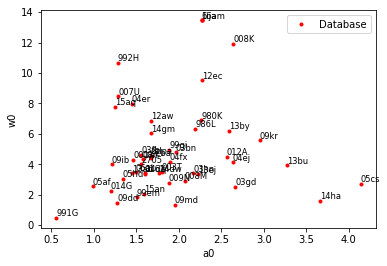

In [13]:
sql = '''SELECT  idsupernovae.`jdexpl`,  supernovanames.`name`, 
sntpt.`a0`,  sntpt.`w0`, sntpt.`m0`, sntpt.`p0`, sntpt.`jdtpt`, 
sntpt.`tptmin`, sntpt.`tptmax`, sntpt.`filter` FROM
sntpt JOIN idsupernovae ON idsupernovae.`id`=sntpt.`targetid` 
JOIN supernovanames ON supernovanames.`targetid`=idsupernovae.`id`
where sntpt.`filter`="V"'''
db, cursor = connect_to_sndavis.get_cursor()
cursor.execute(sql)
result = cursor.fetchall()
for isn in result:
    plt.plot(isn['a0'], isn['w0'], 'r.')
    plt.text(isn['a0'], isn['w0'], isn['name'][-4:], va='bottom', fontsize='small')
plt.plot(isn['a0'], isn['w0'], 'r.', label='Database')
plt.xlabel('a0')
plt.ylabel('w0')
plt.legend(loc='best')
plt.savefig(os.path.join(FIG_DIR, 'a0_w0.pdf'))

w0 and a0 are not direct descriptions of slope and drop but correspond to the fermi-dirac equation, so we have to find that, then approximate the fall from plateau

In [14]:
def get_fall_from_plateau_length(isn):
    sn_lc = supernova.LightCurve2(isn['name'])
    if sn_lc.jdexpl is not None:
        t = sn_lc.jdexpl + np.arange(0, 250)

        tpt_phase = t - isn['jdtpt']
        model = ((-1)*isn['a0'])/(1+np.exp(tpt_phase/isn['w0']))+isn['p0']*tpt_phase+isn['m0']
        slope_indx = (tpt_phase>-5)& (tpt_phase<5)
        top_indx = tpt_phase < tpt_phase[25]
        bottom_indx = tpt_phase > tpt_phase[-25]
        slope_fit = fitter(lin_model, tpt_phase[slope_indx], model[slope_indx])
        top_fit = fitter(lin_model, tpt_phase[top_indx], model[top_indx])
        bottom_fit = fitter(lin_model, tpt_phase[bottom_indx], model[bottom_indx])
        top_intercept = (top_fit.intercept - slope_fit.intercept)/(slope_fit.slope-top_fit.slope)
        bottom_intercept = (bottom_fit.intercept - slope_fit.intercept)/(slope_fit.slope - bottom_fit.slope)
        fall_from_plateau_length = bottom_intercept - top_intercept
        if (fall_from_plateau_length > 30) or (fall_from_plateau_length<5):
            sn_lc.get_photometry()
            plt.figure()
            plt.plot(tpt_phase, top_fit(tpt_phase))
            plt.plot(tpt_phase,slope_fit(tpt_phase))
            plt.plot(tpt_phase, bottom_fit(tpt_phase))
            plt.plot(tpt_phase, model)
            ax = plt.gca()
            ax.set_ylim(model.min()-0.5, model.max()+0.5)
            ax.invert_yaxis()
            ax.plot(sn_lc.jd[isn['filter']]-isn['jdtpt'], sn_lc.apparent_mag[isn['filter']], 'o')
            ax.set_title('{}, length = {}'.format(isn['name'], fall_from_plateau_length))
            ax.axvline(top_intercept, linestyle=':')
            ax.axvline(bottom_intercept, linestyle=':')
            ax.set_xlim(-100, 100)
        if np.isfinite(fall_from_plateau_length):
            return fall_from_plateau_length, slope_fit.slope, slope_fit.intercept+slope_fit.slope*(isn['jdtpt']-sn_lc.jdexpl)
        else:
            return None, None, None
    else:
        return None, None, None

### This displays outlier lengths and then a historgram of all lengths

(array([0., 2., 3., 5., 5., 5., 8., 4., 0., 2., 2., 2., 0., 2.]),
 array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]),
 <a list of 14 Patch objects>)

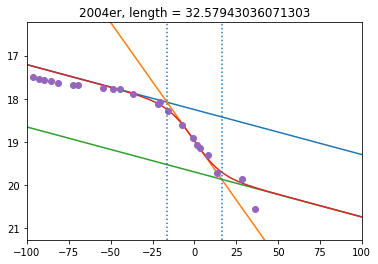

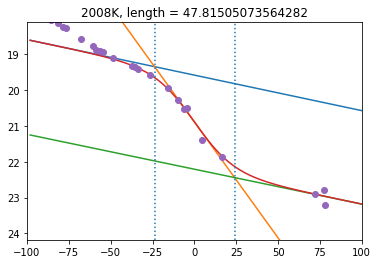

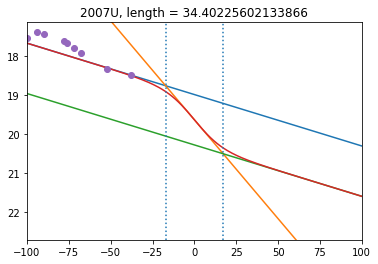

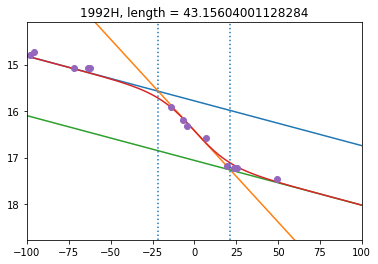

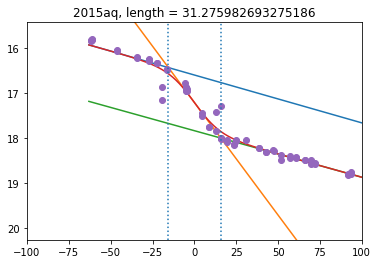

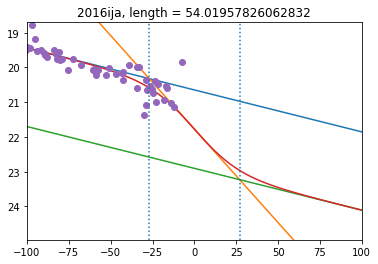

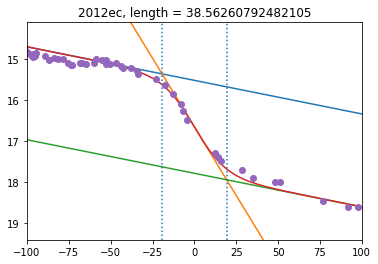

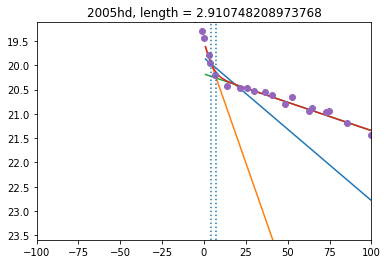

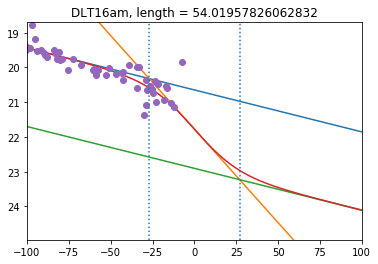

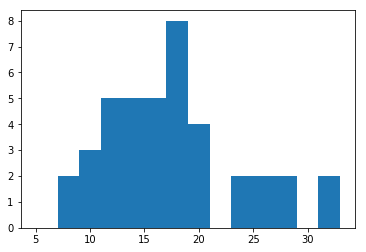

In [15]:
fall_from_plateau_length = []
slopes = []
intercepts = [] #Note that these have been adjusted to phase
used_sn = []
for isn in result:
    temp_fall, temp_slope, temp_intercept = get_fall_from_plateau_length(isn)
    if temp_fall is not None:
        fall_from_plateau_length.append(temp_fall)
        slopes.append(temp_slope)
        intercepts.append(temp_intercept)
        used_sn.append(isn)
plt.figure()
plt.hist(fall_from_plateau_length, bins=np.arange(5, 35, 2))

In [16]:
print(np.median(fall_from_plateau_length))

17.595244844531162


## Conclusions

It turns out that a0 and w0 are not simply a linear slope and intercept and solving for the length of the plateau is not straight forward.
Given that, and the fact that I don't want to run the SNEC models again, I am going to use 135 days and say I made a conservative estimate
based on Valenti et al 2016 figure 5a envelope. 

For plotting purposes, I will use a fall from plateau length of 20 days

For the upper limit I will use a fall from plateau length of 20 days and connect the points between the last plateau observations and the intersection with the radioactive decay tail 20 days later

For the lower limit, I will use a conservative tpt=125d + 10d (half of a 20d fall from plateau)

In [17]:
fall_from_plateau_length = 20 #days

## Upper Limit 

In [18]:
start_fall_phase_upper = tbdata['phase'][s2_indx][-1]
end_fall_phase_upper = start_fall_phase_upper + fall_from_plateau_length

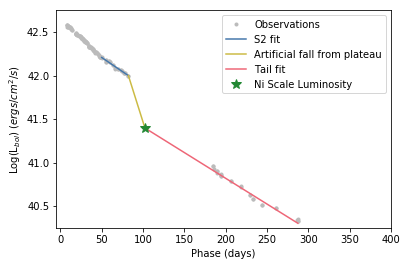

In [19]:
plt.plot(tbdata['phase'], tbdata['logL'], '.', color='#BBBBBB', label='Observations')
plt.plot(tbdata['phase'][s2_indx], s2_fit(tbdata['phase'][s2_indx]), color='#4477AA', label='S2 fit')
plt.plot([start_fall_phase_upper, end_fall_phase_upper], [s2_fit(start_fall_phase_upper), tail_fit(end_fall_phase_upper)], color='#CCBB44', label='Artificial fall from plateau')
tail_phase = np.arange(end_fall_phase_upper, end_tail_phase)
plt.plot(tail_phase, tail_fit(tail_phase), color='#EE6677', label='Tail fit')
plt.plot(end_fall_phase_upper, tail_fit(end_fall_phase_upper), '*', markersize=10, color='#228833', label='Ni Scale Luminosity')
plt.legend(loc='best')
plt.xlim(-5, 400)
plt.ylim(40.25, 42.75)
plt.xlabel('Phase (days)')
plt.ylabel('Log(L$_{bol}$) ($ergs/cm^2/s$)')
plt.savefig(os.path.join(FIG_DIR, 'ni_upper_limit.pdf'))

# Lower Limit

In [20]:
conservative_tpt = 125 #days
end_fall_phase_lower = conservative_tpt+fall_from_plateau_length/2.
start_fall_phase_lower = conservative_tpt-fall_from_plateau_length/2.
tail_phase = np.arange(end_fall_phase_lower, end_tail_phase)
s2_phase = np.arange(tbdata['phase'][s2_indx][0], start_fall_phase_lower)

Text(0,0.5,'Log(L$_{bol}$) ($ergs/cm^2/s$)')

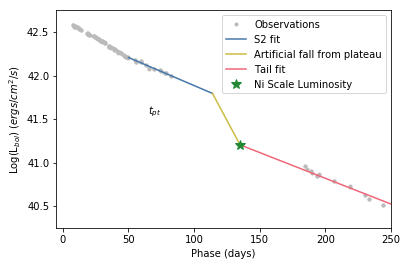

In [21]:

plt.plot(tbdata['phase'], tbdata['logL'], '.', color='#BBBBBB', label='Observations')
plt.plot(s2_phase, s2_fit(s2_phase), color='#4477AA', label='S2 fit')
plt.plot([s2_phase[-1], tail_phase[0]], [s2_fit(s2_phase[-1]), tail_fit(tail_phase[0])], color='#CCBB44', label='Artificial fall from plateau')
plt.plot(tail_phase, tail_fit(tail_phase), color='#EE6677', label='Tail fit')
plt.plot(tail_phase[0], tail_fit(end_fall_phase_lower), '*', markersize=10, color='#228833', label='Ni Scale Luminosity')
#plt.errorbar((conservative_tpt+fall_from_plateau_length/2.)/2., np.mean([s2_fit(s2_phase[-1]), tail_fit(tail_phase[0])]), xerr=(conservative_tpt+fall_from_plateau_length/2.)/2., fmt='k', ecolor='k', capsize=3, zorder=10)
plt.text(65, 41.5, '$t_{pt}$', verticalalignment='bottom')
plt.legend(loc='best')
plt.xlim(-5, 250)
plt.ylim(40.25, 42.75)
plt.xlabel('Phase (days)')
plt.ylabel('Log(L$_{bol}$) ($ergs/cm^2/s$)')


# Get 87A data

In [22]:
tbdata_87A = asc.read('../data/bol_lum_1987A_extrap.txt', names=['phase', 'logL', 'err'])

In [23]:
#end_fall_phase_upper, 
#tail_fit(end_fall_phase_upper)
sn87A_indx = tbdata_87A['phase']>75
sn87A_fit = fitter(lin_model, tbdata_87A['phase'][sn87A_indx], tbdata_87A['logL'][sn87A_indx])#, weights=1/tbdata_87A['err'][sn87A_indx])
sn87A_phase = tbdata_87A['phase'][sn87A_indx]
sn87A_logL = sn87A_fit(sn87A_phase)
sn87A_upper_scale_factor = tail_fit(end_fall_phase_upper)/np.interp(end_fall_phase_upper, sn87A_phase, sn87A_logL)
sn87A_upper_scale_flux = sn87A_logL*sn87A_upper_scale_factor

sn87A_lower_scale_factor = tail_fit(end_fall_phase_lower)/np.interp(end_fall_phase_lower, sn87A_phase, sn87A_logL)
sn87A_lower_scale_flux = sn87A_logL*sn87A_lower_scale_factor

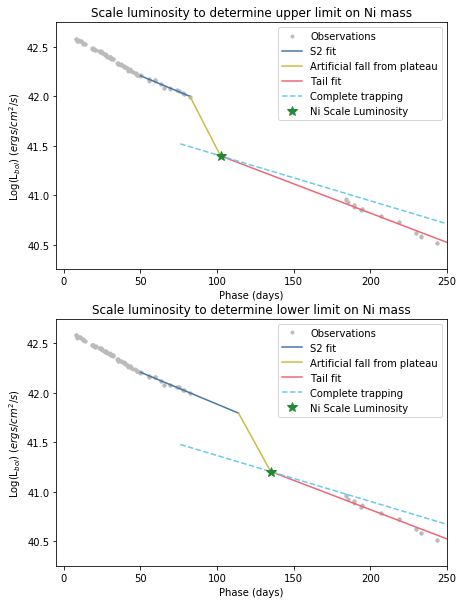

In [340]:
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

start_fall_phase_upper = tbdata['phase'][s2_indx][-1]
end_fall_phase_upper = start_fall_phase_upper + fall_from_plateau_length
tail_phase = np.arange(end_fall_phase_upper, 400)

ax1.plot(tbdata['phase'], tbdata['logL'], '.', color='#BBBBBB', label='Observations')
ax1.plot(tbdata['phase'][s2_indx], s2_fit(tbdata['phase'][s2_indx]), color='#4477AA', label='S2 fit')
ax1.plot([start_fall_phase_upper, end_fall_phase_upper], [s2_fit(start_fall_phase_upper), tail_fit(end_fall_phase_upper)], color='#CCBB44', label='Artificial fall from plateau')
ax1.plot(tail_phase, tail_fit(tail_phase), color='#EE6677', label='Tail fit')
ax1.plot(sn87A_phase, sn87A_upper_scale_flux, ls='--', color='#66CCEE', label='Complete trapping')
ax1.plot(end_fall_phase_upper, tail_fit(end_fall_phase_upper), '*', markersize=10, color='#228833', label='Ni Scale Luminosity')

ax1.legend(loc='best')
ax1.set_xlim(-5, 250)
ax1.set_ylim(40.25, 42.75)
ax1.set_xlabel('Phase (days)')
ax1.set_ylabel('Log(L$_{bol}$) ($ergs/cm^2/s$)')
ax1.set_title('Scale luminosity to determine upper limit on Ni mass')

conservative_tpt = 125 #days
end_fall_phase_lower = conservative_tpt+fall_from_plateau_length/2.
start_fall_phase_lower = conservative_tpt-fall_from_plateau_length/2.
tail_phase = np.arange(end_fall_phase_lower, end_tail_phase)
s2_phase = np.arange(tbdata['phase'][s2_indx][0], start_fall_phase_lower)

ax2.plot(tbdata['phase'], tbdata['logL'], '.', color='#BBBBBB', label='Observations')
ax2.plot(s2_phase, s2_fit(s2_phase), color='#4477AA', label='S2 fit')
ax2.plot([s2_phase[-1], tail_phase[0]], [s2_fit(s2_phase[-1]), tail_fit(tail_phase[0])], color='#CCBB44', label='Artificial fall from plateau')
ax2.plot(tail_phase, tail_fit(tail_phase), color='#EE6677', label='Tail fit')
ax2.plot(sn87A_phase, sn87A_lower_scale_flux, ls='--', color='#66CCEE', label='Complete trapping')
ax2.plot(tail_phase[0], tail_fit(end_fall_phase_lower), '*', markersize=10, color='#228833', label='Ni Scale Luminosity')
ax2.legend(loc='best')
ax2.set_xlim(-5, 250)
ax2.set_ylim(40.25, 42.75)
ax2.set_xlabel('Phase (days)')
ax2.set_ylabel('Log(L$_{bol}$) ($ergs/cm^2/s$)')
ax2.set_title('Scale luminosity to determine lower limit on Ni mass')
plt.savefig(os.path.join(FIG_DIR, 'ni_mass_lc.pdf'))

In [189]:
print(end_fall_phase_upper)
print(end_fall_phase_lower)

86.4708375134
135.0


(39, 42.2)

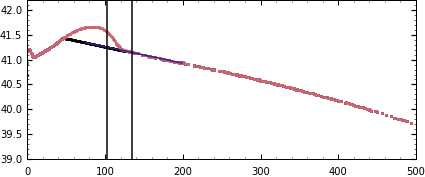

In [70]:
tbdata_87A = asc.read('../data/bol_lum_1987A_extrap.txt', names=['phase', 'logL', 'err'])
sn87A_tbdata = asc.read('../../not_my_code/sndavis/data/1987A_bolo_UBVRI.txt',
                       names=['phase', 'logL', 'err'])
sn87A_indx = (tbdata_87A['phase']>75)&(tbdata_87A['phase']<100)
sn87A_fit = fitter(lin_model, tbdata_87A['phase'][sn87A_indx], tbdata_87A['logL'][sn87A_indx])
plt.plot(tbdata_87A['phase'], tbdata_87A['logL'], '.')
plt.plot(sn87A_tbdata['phase'], sn87A_tbdata['logL'], '.')
plt.plot(np.arange(75, 200), sn87A_fit(np.arange(75, 200)))
plt.axvline(end_fall_phase_lower)
plt.axvline(end_fall_phase_upper)
plt.xlim(0, 500)
plt.ylim(39, 42.2)

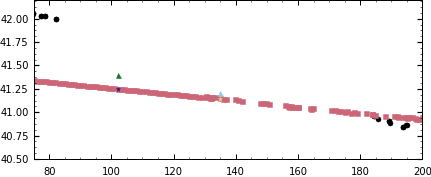

In [71]:
plt.plot(tbdata['phase'], tbdata['logL'], 'o')
plt.plot(tbdata_87A['phase'], tbdata_87A['logL'], 's')
plt.plot(end_fall_phase_upper, sn87A_fit(end_fall_phase_upper), '*')
plt.plot(end_fall_phase_lower, sn87A_fit(end_fall_phase_lower), '*')
plt.plot(end_fall_phase_upper, tail_fit(end_fall_phase_upper) , '^')
plt.plot(end_fall_phase_lower, tail_fit(end_fall_phase_lower) , '^')
plt.xlim(75, 200)
plt.ylim(40.5, 42.2)
ax = plt.gca()


In [76]:
L87A_upper = 10**sn87A_fit(end_fall_phase_upper)
L87A_lower = 10**sn87A_fit(end_fall_phase_lower)
LSN_upper = 10**tail_fit(end_fall_phase_upper) 
LSN_lower = 10**tail_fit(end_fall_phase_lower) 

M_Ni_upper = 0.075*LSN_upper/L87A_upper
M_Ni_lower = 0.075*LSN_lower/L87A_lower

print('Ni upper mass limit ={:2.3f}'.format(M_Ni_upper))
print('Ni lower mass limit = {:2.3f}'.format(M_Ni_lower))

Ni upper mass limit =0.105
Ni lower mass limit = 0.086
